Let's start by creating a mapping of gene oncology (GO) term IDS to their label indices for each of the three subgraphs of the gene ontology.

In [74]:
from itertools import islice

obo_file_path = "./dataset/train/go-basic.obo"

bp_terms, cc_terms, mf_terms, all_terms = [], [], [], []

with open(obo_file_path, 'r') as file:
    data = file.read().split("[Term]")

for term_data in data[1:]:  # Skip the first element as it is before the first [Term].
    lines = term_data.strip().splitlines()

    term_id = None
    namespace = None

    for line in lines:
        if line.startswith("id:"):
            term_id = line.split("id:")[1].strip()
        elif line.startswith("namespace:"):
            namespace = line.split("namespace:")[1].strip()

        if term_id and namespace:
            match namespace:
                case "biological_process":
                    bp_terms.append(term_id)
                case "cellular_component":
                    cc_terms.append(term_id)
                case "molecular_function":
                    mf_terms.append(term_id)
            
            all_terms.append(term_id)

            break

# Print the first 10 terms.
for term_mapping in [all_terms, bp_terms, cc_terms, mf_terms]:
    for label_index, term_id in enumerate(term_mapping[:5]):
        print(f"{term_id} => {label_index}")

    print("\n")


GO:0000001 => 0
GO:0000002 => 1
GO:0000003 => 2
GO:0000005 => 3
GO:0000006 => 4


GO:0000001 => 0
GO:0000002 => 1
GO:0000003 => 2
GO:0000011 => 3
GO:0000012 => 4


GO:0000015 => 0
GO:0000108 => 1
GO:0000109 => 2
GO:0000110 => 3
GO:0000111 => 4


GO:0000005 => 0
GO:0000006 => 1
GO:0000007 => 2
GO:0000008 => 3
GO:0000009 => 4




Next, let's count the number of unique GO terms so we know how many classes we need to represent in the output layer of the Transformer.

In [75]:
all_num_classes = len(all_terms)
num_bp_classes = len(bp_terms)
num_cc_classes = len(cc_terms)
num_mf_classes = len(mf_terms)

print(f"Number of biological process classes: {num_bp_classes:,}")
print(f"Number of cellular component classes: {num_cc_classes:,}")
print(f"Number of molecular function classes: {num_mf_classes:,}")

print(f"Total number of classes: {all_num_classes:,}")

Number of biological process classes: 30,510
Number of cellular component classes: 4,469
Number of molecular function classes: 12,438
Total number of classes: 47,417


Now let's map the sequence IDs to their GO term label indices. We'll also count the GO terms so we can plot them later.

In [76]:
import pandas as pd

from collections import defaultdict, Counter

terms_path = "./dataset/train/train_terms.tsv"

all_counter = Counter()
bp_counter = Counter()
cc_counter = Counter()
mf_counter = Counter()

# Convert to dict for O(1) label index lookup.
all_terms = {term: index for index, term in enumerate(all_terms)}
bp_terms = {term: index for index, term in enumerate(bp_terms)}
cc_terms = {term: index for index, term in enumerate(cc_terms)}
mf_terms = {term: index for index, term in enumerate(mf_terms)}

all_seq_to_label_indices = defaultdict(list)
bp_seq_to_label_indices = defaultdict(list)
cc_seq_to_label_indices = defaultdict(list)
mf_seq_to_label_indices = defaultdict(list)

df = pd.read_csv(terms_path, sep='\t')

for _, row in df.iterrows():
    sequence_id = row["EntryID"]
    term_id = row["term"]

    match row["aspect"]:
        case "BPO":
            label_index = bp_terms[term_id]
            bp_seq_to_label_indices[sequence_id].append(label_index)
            bp_counter[term_id] += 1
        case "CCO":
            label_index = cc_terms[term_id]
            cc_seq_to_label_indices[sequence_id].append(label_index)
            cc_counter[term_id] += 1
        case "MFO":
            label_index = mf_terms[term_id]
            mf_seq_to_label_indices[sequence_id].append(label_index)
            mf_counter[term_id] += 1
    
    label_index = all_terms[term_id]
    all_seq_to_label_indices[sequence_id].append(label_index)
    all_counter[term_id] += 1

all_first_10 = dict(islice(all_seq_to_label_indices.items(), 10))
bp_first_10 = dict(islice(bp_seq_to_label_indices.items(), 10))
cc_first_10 = dict(islice(cc_seq_to_label_indices.items(), 10))
mf_first_10 = dict(islice(mf_seq_to_label_indices.items(), 10))

# Print the first 10 sequence to label index mappings.
for sequence_to_label_mapping in [all_first_10, bp_first_10, cc_first_10, mf_first_10]:
    for sequence_id, label_indices in sequence_to_label_mapping.items():
        print(f"{sequence_id} => {label_indices}")

    print("\n")

A0A009IHW8 => [6130, 17759, 33427, 21998, 5218, 40751, 21979, 40817, 6129, 41016, 41017, 6987, 4668, 22006, 23863, 12080, 23851, 28851, 21986, 12152, 12342, 5265, 12378, 40818, 4687, 24055, 7801, 5194, 5254, 17745, 33425, 32690, 12082, 41027, 33430, 23803, 7033, 33428, 4719, 6928, 21980, 5251, 12375, 2628, 2856, 10504, 10514, 10513, 2743]
A0A021WW32 => [26053, 26041, 13187, 31037, 5667, 5473, 36072, 20451, 25726, 6129, 42410, 5777, 8384, 26872, 25678, 11949, 13523, 241, 25679, 546, 13220, 25921, 38541, 5464, 25889, 7710, 10126, 15704, 29141, 7801, 9891, 32815, 5475, 8407, 12883, 5477, 25528, 5421, 53, 239, 13550, 15703, 8264, 25857, 31227, 27340, 32681, 36345, 191, 4204, 21059, 524, 527, 521, 21064, 16155, 21062, 21065, 4215, 4278, 21061, 15210, 525, 35953, 21066, 4273, 4160, 22479, 4268, 526, 6245, 38223, 4289, 31051, 21060, 515, 15204]
A0A023FFD0 => [29188, 7783, 31037, 8427, 29186, 13372, 6129, 46282, 8265, 27171, 26997, 26872, 8425, 26995, 21852, 39621, 26876, 7781, 25785, 19984, 1

Next thing we'll do is plot the top k GO terms for each subgraph using a bar chart.

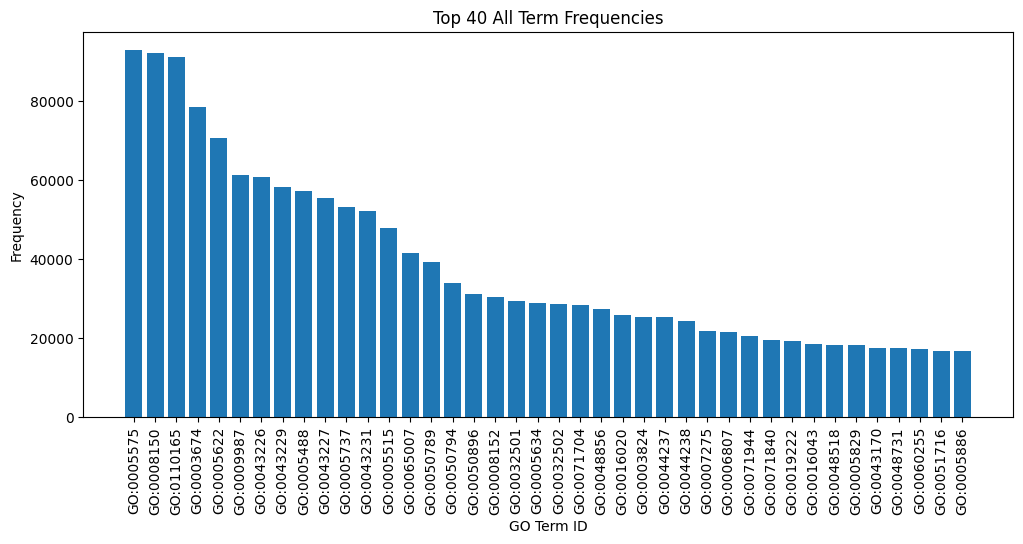

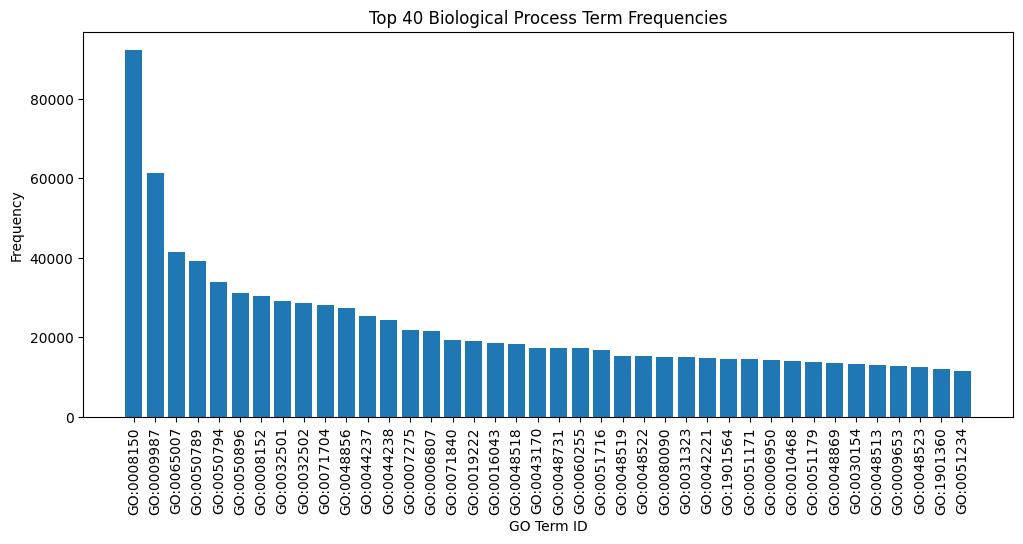

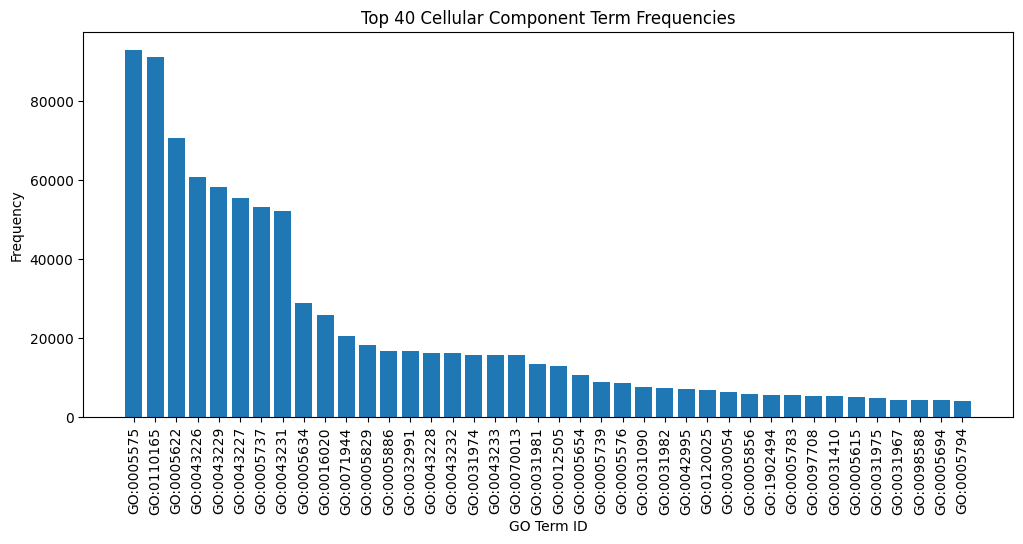

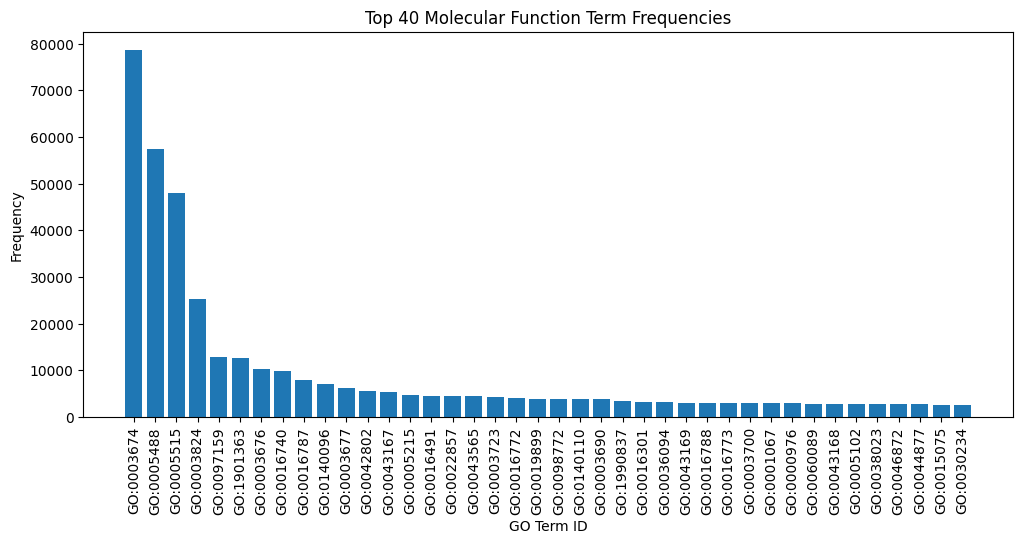

In [77]:
import matplotlib.pyplot as plt

top_k = 40

for name, counter in [
    ("All", all_counter),
    ("Biological Process", bp_counter),
    ("Cellular Component", cc_counter),
    ("Molecular Function", mf_counter),
]:
    counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

    first_k = dict(islice(counter.items(), top_k))

    plt.figure(figsize=(12, 5)) 

    plt.bar(first_k.keys(), first_k.values())

    plt.xticks(rotation=90)
    plt.xlabel("GO Term ID")
    plt.ylabel("Frequency")
    plt.title(f"Top {top_k} {name} Term Frequencies")

    plt.show()

Let's read through the training samples and create a new JSONL dataset that contains the raw protein sequences and a list of their GO term label indices for each of the GO subgraphs. This will be the file that we read from when fine-tuning the model.

In [78]:
import json

from Bio import SeqIO

fasta_path = "./dataset/train/train_sequences.fasta"

all_dataset_path = "./dataset/all_dataset.jsonl"
mf_dataset_path = "./dataset/mf_dataset.jsonl"
bp_dataset_path = "./dataset/bp_dataset.jsonl"
cc_dataset_path = "./dataset/cc_dataset.jsonl"


for dataset_path, sequence_to_label_indices in [
    (all_dataset_path, all_seq_to_label_indices),
    (mf_dataset_path, mf_seq_to_label_indices),
    (bp_dataset_path, bp_seq_to_label_indices),
    (cc_dataset_path, cc_seq_to_label_indices),
]:
    with open(dataset_path, "w") as dataset_file:   
        with open(fasta_path, "r") as fasta_file:
            for record in SeqIO.parse(fasta_file, "fasta"):
                sequence_id = record.id
                sequence = str(record.seq)

                label_indices = sequence_to_label_indices[sequence_id]

                line = {
                    "sequence_id": sequence_id,
                    "sequence": sequence,
                    "label_indices": label_indices
                }

                dataset_file.write(json.dumps(line) + "\n")

            print(f"Dataset saved to {dataset_path}")



Dataset saved to ./dataset/all_dataset.jsonl
Dataset saved to ./dataset/mf_dataset.jsonl
Dataset saved to ./dataset/bp_dataset.jsonl
Dataset saved to ./dataset/cc_dataset.jsonl


At inference time, we'll need to map the label index back to the GO term in the graphical structure. For that we can reverse our current mappings and store them as a JSON structure.

In [79]:
all_label_mapping_path = "./dataset/all_label_mapping.json"
bp_label_mapping_path = "./dataset/bp_label_mapping.json"
cc_label_mapping_path = "./dataset/cc_label_mapping.json"
mf_label_mapping_path = "./dataset/mf_label_mapping.json"

all_terms = [term for term in all_terms.keys()]
bp_terms = [term for term in bp_terms.keys()]
cc_terms = [term for term in cc_terms.keys()]
mf_terms = [term for term in mf_terms.keys()]

for path, terms in [
    (all_label_mapping_path, all_terms),
    (bp_label_mapping_path, bp_terms),
    (cc_label_mapping_path, cc_terms),
    (mf_label_mapping_path, mf_terms),
]:
    with open(path, "w") as file:
        file.write(json.dumps(terms) + "\n")

        print(f"Label mapping saved to {path}")



Label mapping saved to ./dataset/all_label_mapping.json
Label mapping saved to ./dataset/bp_label_mapping.json
Label mapping saved to ./dataset/cc_label_mapping.json
Label mapping saved to ./dataset/mf_label_mapping.json
